TODO:

- decide on brain state data structure (maybe reformat it inside of the sim?)
- add text describing brain state/mental state/mental representation/functionalism/etc..
- clean up the NN models / function calls on the networks to make them more intuitive for explaination
- clean up trainedmentalagent construction / class code
- nicely package training scripts for behavior and mental state classification (implement train/test for mental state clf)
- fix all the pytorch cuda/cpu drama
- set random seeds for all sims
- add explainations/text throughout notebook
- general notebook cleaning
- make notebook work on colab

# Overview

- Many theories of mind rest on how brain states and mental states are defined and their relationship.
- I want to try to (faithfully to most theories of mind) define brain states, mental states, and their relationships in code.
- We can then use these definitions to build descriptions of theories of mind in code.
- I am not presenting a cognitive architecture or even accepting computational theory of mind. 
- *I'm simply trying to use code to more clearly talk about what we mean and have more concrete disagreements.*
- Like a thought experiment, but with a simulate buttom.

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import clear_output
import world
from dqn_agent import DQNAgent
from visualization_utils import *
from model import MLP

%matplotlib inline

# Feel for the simulation world

In [2]:
%%HTML
<video width="480" height="360" controls>
  <source src="../openai_lunarlander_video.mp4" type="video/mp4">
</video>

# Feel for how agents are described

## An agent who takes no actions

In [3]:
class DoNothingAgent(object):
    
    name = 'do_nothing_agent'

    def __init__(self):
        pass

    def act(self, world_observation):
        return 0

    
agent = DoNothingAgent()

_ = world.run_episode(agent)

## An agent who takes random actions

In [4]:
class RandomAgent(object):
    
    name = 'random_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_observation):
        return random.randint(0, self.num_actions-1)

    
agent = RandomAgent()

_ = world.run_episode(agent)

## An agent that was trained (using reinforcement learning) to perform well in the environment

In [5]:
class Brain(object):
    
    def __init__(self, use_pretrained=True):
        if use_pretrained=True:
            self.network = BehaviorNetwork('../checkpoint0.pth')
        else:
            self.network = BehaviorNetwork()
            self.network.train('LunarLander-v2')
            
    def _brain_state(self, world_observation):
        brain_state = []
        network = self.network
        x = world_observation
        activations = x
        for i, subnet in enumerate(network.children()):
            try:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations.detach().clone().cpu().numpy()
            except AttributeError:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations
            brain_state.append(subbrain_state)
            activations = F.relu(subnet.cpu().float()(torch.tensor(activations).float()))
        return brain_state
    
    def image_brain_state(self, world_observation):
        return self._brain_state(world_observation)


class TrainedBehaviorAgent(object):
    
    name = 'trained_behavior_agent'

    def __init__(self):
        self.dqn_agent = DQNAgent()
        self.dqn_agent.qnetwork_local.load_state_dict(torch.load('../checkpoint0.pth', map_location='cpu'))
        self.dqn_agent.qnetwork_local.fc1.cpu()
        self.dqn_agent.qnetwork_local.fc2.cpu()
        self.dqn_agent.qnetwork_local.fc3.cpu()

    def act(self, world_observation):
        return self.dqn_agent.act(world_observation)
    
    def brain_state(self, world_observation):
        
        brain_state = []
        
        network = self.dqn_agent.qnetwork_local
        x = world_observation
        activations = x
        for i, subnet in enumerate(network.children()):
            try:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations.detach().clone().cpu().numpy()
            except AttributeError:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations
            brain_state.append(subbrain_state)
            activations = F.relu(subnet.cpu().float()(torch.tensor(activations).float()))
            

        return brain_state
        

    
agent = TrainedBehaviorAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [6]:
print(agent.dqn_agent.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


In [7]:
agent.dqn_agent.qnetwork_local.fc2.weight.is_cuda

False

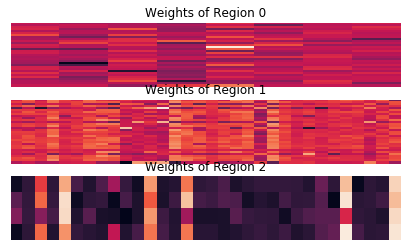

In [8]:
visualize_weights(agent.dqn_agent.qnetwork_local)

../visualization_utils.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activations = F.relu(subnet.cpu().float()(torch.tensor(activations).float()))


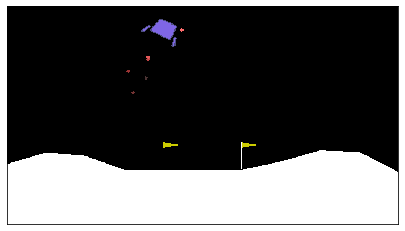

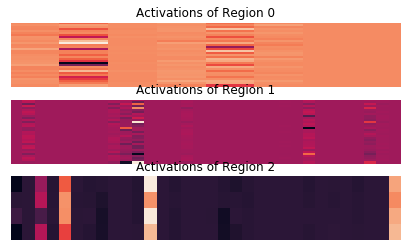

In [9]:
episode_index = 50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['world_observation'][episode_index])

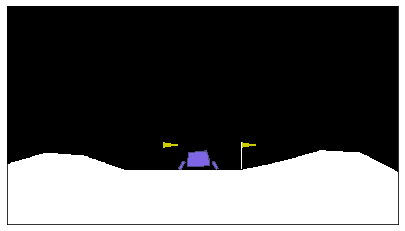

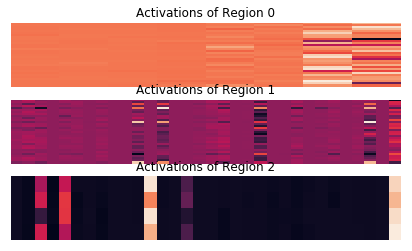

In [10]:
episode_index = -50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['world_observation'][episode_index])

## An agent that was trained (using reinforcement learning) to perform well in the environment and was trained (using supervised learning) to recognize its own mental states

In [11]:
mental_state_labels = [
    ["I believe I'm falling to fast", lambda state: state[3] < -0.2],
    ["I desire to land", lambda state: state[-2] != 1 and state[-1] != 1],
    ["I'm afraid to tip over", lambda state: np.abs(state[5]) > 0.2],
    ["I desire to go left", lambda state: state[0] > 0.2],
    ["I desire to go right", lambda state: state[0] < -0.2]
]

class TrainedMentalAgent(TrainedBehaviorAgent):
    
    name = 'trained_mental_agent'

    def __init__(self):
        super(TrainedMentalAgent, self).__init__()
        self.mental_state_classifier = MLP(num_neurons=1408, 
                                           num_mental_states=len(mental_state_labels), 
                                           fc_units=32)
        self.mental_state_classifier.load_state_dict(torch.load('../mental_classifer.pth'))
        self.mental_state_classifier.cpu()
        self.mental_state_labels = mental_state_labels
        
    def report_mental_state(self, state):
        brain_state = self.brain_state(state)
        brain_state = np.concatenate([array.flatten() for array in brain_state])
        mental_state = F.sigmoid(self.mental_state_classifier(torch.tensor(brain_state).float())).detach().clone().cpu().numpy()
        return [agent.mental_state_labels[i][0] for i, m in enumerate(mental_state) if m > 0.5]


agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


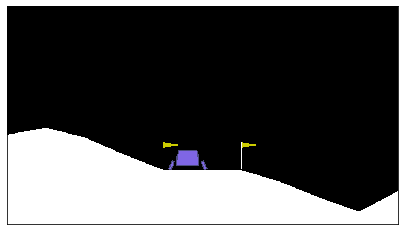

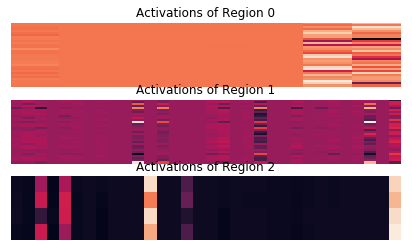

In [12]:
animate_episode_history(episode_history, agent, steps_size=25, pause=3)

# Common theories of mind

## Behaviorism

In [13]:
# Adapted from OpenAI's heuristic controller for lunar lander 

class BehaviorismAgent(object):
    
    name = 'behaviorism_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_observation):
        s = world_observation
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        if s[6] or s[7]:
            angle_todo, hover_todo = 0, -(s[3])*0.5 
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05: 
            a = 3
        elif angle_todo > +0.05: 
            a = 1
        return a

    
agent = BehaviorismAgent()

episode_history = world.run_episode(agent)

episode_history['brain_state'] = None
episode_history['reported_mental_state'] = None

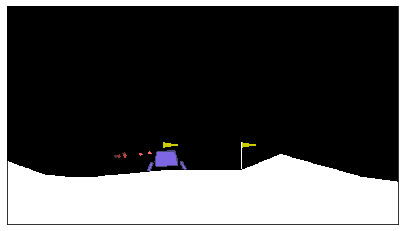

In [14]:
animate_episode_history(episode_history, agent, steps_size=50, pause=1)

## Token-token Identity Theory

In [15]:
agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


I desire to land


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


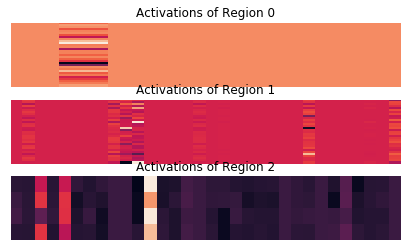

In [16]:
state = np.asarray([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

I desire to land


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


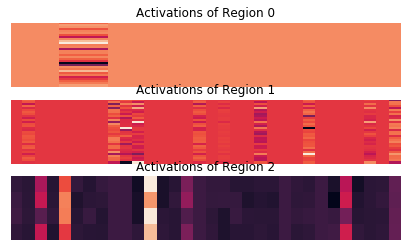

In [17]:
state = np.asarray([0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

I'm afraid to tip over


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


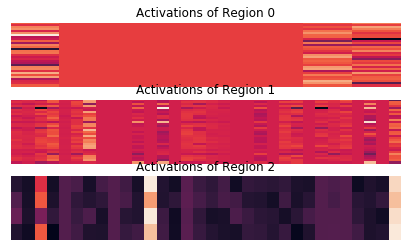

In [18]:
state = np.asarray([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

I'm afraid to tip over


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


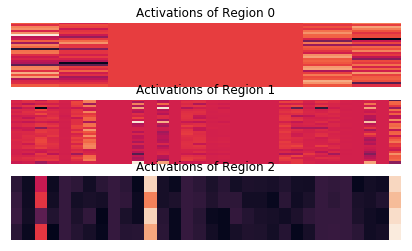

In [19]:
state = np.asarray([1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

## Functionalism

In [20]:
class FunctionalismAgent(object):
    
    name = 'functionalism_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_observation):
        
        if self.falling_too_fast_belief_mental_state(world_observation):
            a = 2
        elif self.fear_of_tipping_to_the_left(world_observation):
            a = 3
        elif self.fear_of_tipping_to_the_right(world_observation):
            a = 1
        elif self.desire_go_left_mental_state(world_observation):
            a = 1
        elif self.desire_go_right_mental_state(world_observation):
            a = 3
        elif self.desire_to_land_mental_state(world_observation):
            a = 0
        else:
            a = 0
        return a
    
    def fear_of_tipping_to_the_left(self, world_observation):
        s = world_observation
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        return (not (hover_todo > np.abs(angle_todo) and hover_todo > 0.05) 
                and angle_todo < -0.05)
    
    def fear_of_tipping_to_the_right(self, world_observation):
        s = world_observation
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        return (not (hover_todo > np.abs(angle_todo) and hover_todo > 0.05) 
                and angle_todo > +0.05)
    
    def falling_too_fast_belief_mental_state(self, world_observation):
        return world_observation[3] < -0.2
    
    def desire_to_land_mental_state(self, world_observation):
        return (world_observation[-2] != 1 and world_observation[-1] != 1)
    
    def desire_go_left_mental_state(self, world_observation):
        return world_observation[0] > 0.1
    
    def desire_go_right_mental_state(self, world_observation):
        return world_observation[0] < -0.1
        

    
agent = FunctionalismAgent()

episode_history = world.run_episode(agent)

# Open implementation questions

## Should the mental classificaiton network be part of the brain state? How does this answer depend on the chosen theory of mind?

In [21]:
agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


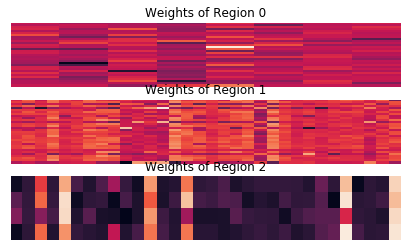

In [22]:
visualize_weights(agent.dqn_agent.qnetwork_local)

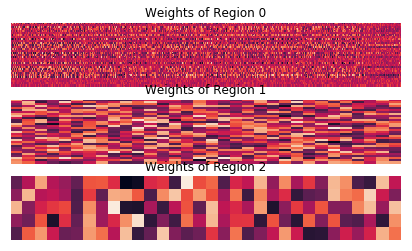

In [23]:
visualize_weights(agent.mental_state_classifier)

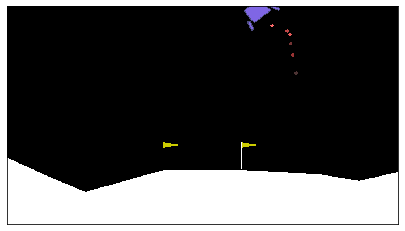

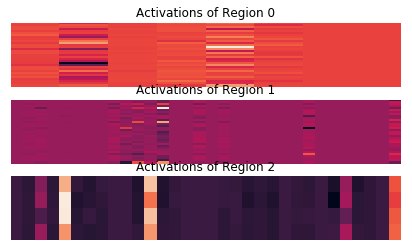

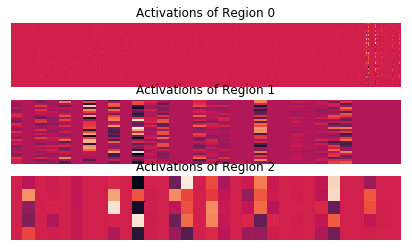

In [24]:
episode_index = 50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['world_observation'][episode_index])
brain_state = np.concatenate([array.flatten() for array in episode_history['brain_state'][episode_index]])
visualize_activations(agent.mental_state_classifier, brain_state)

## The agent is epiphenomenal

# Future work

- Dennett multiple drafts model of consciousness
- Chalmers types of materialism
- Non reductive materialism: Strawson's realistic monism, Davidson's anomalous monism
- Weak emergence
- Eliminative materialism
- Searle's biological naturalism
- Thoughts? Suggestions?